The goal of this notebook is to have a first functional workflow with a 'simple' model

__Roadmap__

1. Data prep into a tf.dataset object with the relevant features. Done with tokenizer.
    - sequence
    - masking 
    - offset mapping 


2. Create model via transfer learning
    

## Imports & Variables

In [2]:
try:
  from google.colab import drive
  !pip install --quiet transformers
except:
  print('Welcome on your Notebook')

     |████████████████████████████████| 3.4 MB 5.5 MB/s 
     |████████████████████████████████| 67 kB 4.5 MB/s 
     |████████████████████████████████| 596 kB 55.1 MB/s 
     |████████████████████████████████| 895 kB 41.5 MB/s 
     |████████████████████████████████| 3.3 MB 35.7 MB/s 


In [3]:
#canonicals
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

#hugging face
from transformers import BertTokenizer, TFBertModel

#utils
from tqdm.notebook import tqdm_notebook

In [12]:
# Change this to work with a sample of the data or the full dataset
SAMPLE_MODE = False

#Max length of a discourse (refers to explorator nb)
DISCOURSE_LEN = 256

#change this to run again the tokenizer. If set to false will fetch npz files in the directory 
TOKENIZE = False

#Set TRAIN, VAL, TEST splits:
VAL_SPLIT=0.8
TEST_SPLIT=0.9

#Batch size
BATCH_SIZE = 256

#Paths saved TF datasets
PATH_TF_DATASET='/content/drive/MyDrive/feedback-prize/datasets'

## Data

In [5]:
if SAMPLE_MODE:
    n_rows=15000-9
else: 
    n_rows=None

try:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/feedback-prize

  df = pd.read_csv('train_filled.csv',nrows=n_rows,index_col=0)

except:
  df = pd.read_csv('../raw_data/train_filled.csv',nrows=n_rows,index_col=0)

df.reset_index(drop=True, inplace=True)
df['discourse_text'].fillna(' ',inplace=True)

Mounted at /content/drive
/content/drive/MyDrive/feedback-prize


In [6]:
## Splitting into train, val and test 

## setting for the exact right index : we don't wan't to split 
## an essay between 2 sets

idx_val=int(len(df)*VAL_SPLIT)
idx_test=int(len(df)*TEST_SPLIT)

for i in range(idx_val,idx_val+20):
    if df.loc[i,'id'] != df.loc[i+1,'id']:
        idx_val=i
        break
        
for i in range(idx_test,idx_test+20):
    if df.loc[i,'id'] != df.loc[i+1,'id']:
        idx_test=i
        break
        
#display(df.loc[idx_val-2:idx_val+2],df.loc[idx_test-2:idx_test+2],idx_val,idx_test)

assert(df.loc[idx_val,'id']!=df.loc[idx_val+1,'id'])
assert(df.loc[idx_test,'id']!=df.loc[idx_test+1,'id'])

idx_train=list(range(0,idx_val))
idx_val=list(range(idx_val,idx_test))
idx_test=list(range(idx_test,len(df)))

assert(len(idx_test)+len(idx_train)+len(idx_val)==len(df))


## Tokenizer

In [7]:
## create labels dict and map it
labels={l:i for i,l in enumerate(df.discourse_type.unique())}

df['label']=df['discourse_type'].map(labels)

In [8]:
## create x_train,x_test,x_val
x_train = df['discourse_text'].values[idx_train]
x_val = df['discourse_text'].values[idx_val]
x_test = df['discourse_text'].values[idx_test]

In [9]:
## create y_train, y_test, y_val 
y_train_ = df['label'].values[idx_train]
y_val_ = df['label'].values[idx_val]
y_test_ = df['label'].values[idx_test]

## ohe
y_train = np.zeros((len(idx_train),len(labels)))
y_val = np.zeros((len(idx_val),len(labels)))
y_test = np.zeros((len(idx_test),len(labels)))

y_train[np.arange(len(y_train_)),y_train_]=1
y_val[np.arange(len(y_val_)),y_val_]=1
y_test[np.arange(len(y_test_)),y_test_]=1

#convert to tensors
y_train = tf.convert_to_tensor(y_train,dtype='int32')
y_val = tf.convert_to_tensor(y_val,dtype='int32')
y_test = tf.convert_to_tensor(y_test,dtype='int32')

assert(y_test.shape[1]==8)

In [10]:
#initiate tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
## tokenize train,val,test

if TOKENIZE:

  x_train_tok=tokenizer(list(x_train),truncation=True,max_length=DISCOURSE_LEN,padding='max_length',
              return_token_type_ids=False,return_tensors='tf')
  x_val_tok=tokenizer(list(x_val),truncation=True,max_length=DISCOURSE_LEN,padding='max_length',
              return_token_type_ids=False,return_tensors='tf')
  x_test_tok=tokenizer(list(x_test),truncation=True,max_length=DISCOURSE_LEN,padding='max_length',
              return_token_type_ids=False,return_tensors='tf')
  
    # Now we can store all our tokenized tensors 

  with open('x_train.npz','wb') as file:
    np.savez(file,input_ids=x_train_tok['input_ids'],attention_mask=x_train_tok['attention_mask']) 

  with open('x_val.npz','wb') as file:
    np.savez(file,input_ids=x_val_tok['input_ids'],attention_mask=x_val_tok['attention_mask']) 

  with open('x_test.npz','wb') as file:
    np.savez(file,input_ids=x_test_tok['input_ids'],attention_mask=x_test_tok['attention_mask']) 
  
else:
  print('Running the notebook in TOKENIZE=False mode')

Running the notebook in TOKENIZE=False mode


In [15]:
if not TOKENIZE:

  ## We load our pre-tokenized data and store them into tensors

  with open('x_train.npz','rb') as file:
    arrays_tmp = np.load(file, allow_pickle=False) 
    x_train_tok = dict(input_ids = tf.convert_to_tensor(arrays_tmp['input_ids']),
                       attention_mask = tf.convert_to_tensor(arrays_tmp['attention_mask']))

  with open('x_val.npz','rb') as file:
    arrays_tmp = np.load(file, allow_pickle=False) 
    x_val_tok = dict(input_ids = tf.convert_to_tensor(arrays_tmp['input_ids']),
                       attention_mask = tf.convert_to_tensor(arrays_tmp['attention_mask']))
    
  with open('x_test.npz','rb') as file:
    arrays_tmp = np.load(file, allow_pickle=False) 
    x_test_tok = dict(input_ids = tf.convert_to_tensor(arrays_tmp['input_ids']),
                       attention_mask = tf.convert_to_tensor(arrays_tmp['attention_mask']))

In [17]:
## Creating tf datasets objects

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_tok,y_train)).batch(BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_tok,y_val)).batch(BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_tok,y_test)).batch(BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE)

In [16]:
x_train_tok

{'attention_mask': <tf.Tensor: shape=(134072, 256), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_ids': <tf.Tensor: shape=(134072, 256), dtype=int32, numpy=
 array([[  101,  2070,  2111, ...,     0,     0,     0],
        [  101,  2009,  2001, ...,     0,     0,     0],
        [  101,  1037, 15797, ...,     0,     0,     0],
        ...,
        [  101,  2070,  2111, ...,     0,     0,     0],
        [  101,  2027,  2097, ...,     0,     0,     0],
        [  101,  4661,  1010, ...,     0,     0,     0]], dtype=int32)>}

## Modeling

In [18]:
pretrained_bert = TFBertModel.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [19]:
def init_model():
    input_ids = tf.keras.layers.Input(shape=(DISCOURSE_LEN,),dtype='int32')
    attention_mask = tf.keras.layers.Input(shape=(DISCOURSE_LEN,),dtype='int32')
    x = pretrained_bert({'input_ids':input_ids,
                         'attention_mask':attention_mask})[0]
    # x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(.2)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    output = tf.keras.layers.Dense(8, activation='softmax',name='outputs')(x)

    pretrained_bert.trainable=False
    
    model = tf.keras.Model(inputs={'input_ids':input_ids,
                                   'attention_mask':attention_mask},
                           outputs=output)
    
    return model

In [20]:
#init model and print summary
model = init_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_2[0][0]',                
                                thPoolingAndCrossAt               'input_1[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

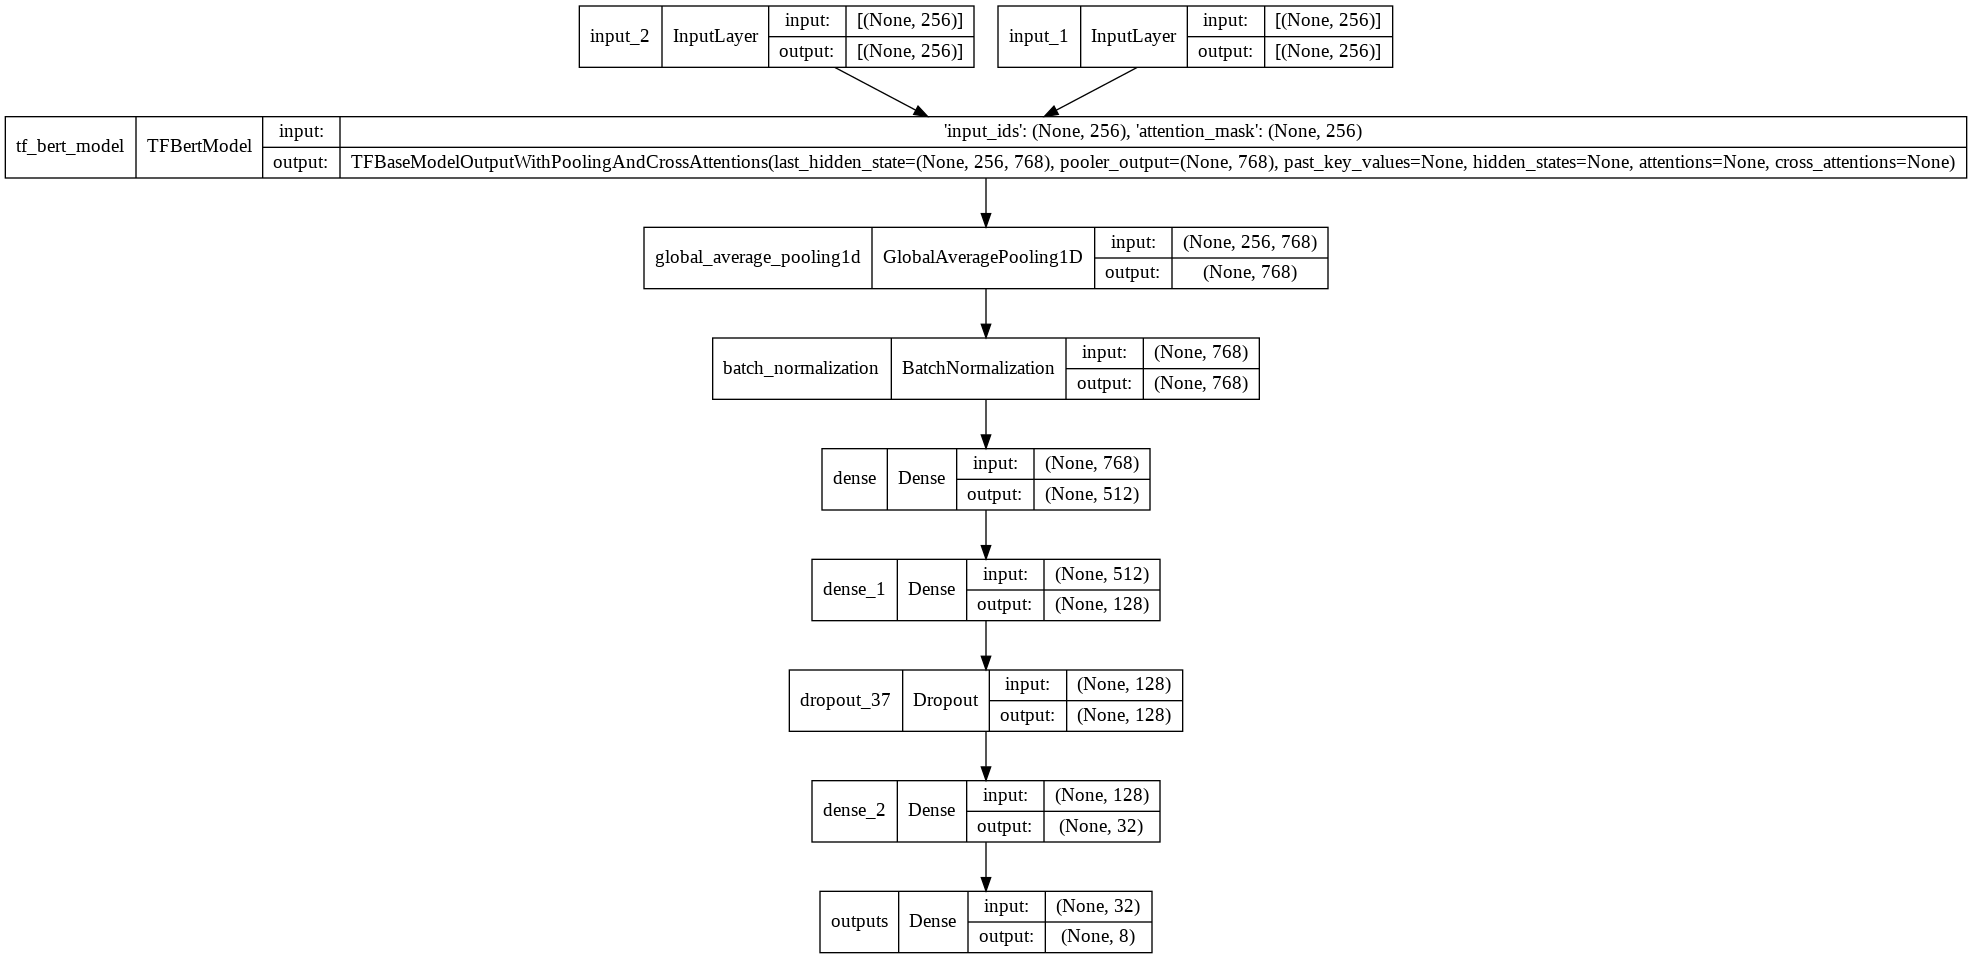

In [21]:
#show graph
tf.keras.utils.plot_model(model,show_shapes=True)

In [22]:
## calcul number of iterations / epochs
n_batches = int(len(x_train_tok['input_ids']))/BATCH_SIZE +1
n_batches

524.71875

In [23]:
# compile model
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')
acc = tf.keras.metrics.CategoricalAccuracy(name='accuracy')

initial_learning_rate = 0.1

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                                            initial_learning_rate,
                                            decay_steps=200,
                                            decay_rate=0.6,
                                            staircase=True)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=opt,loss=loss,metrics=[acc])

In [24]:
## creating callback and checkpoint saver
es = tf.keras.callbacks.EarlyStopping(patience=1,restore_best_weights=True)

checkpoint_saver = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/feedback-prize/checkpoints',
                                                      save_weights_only=True,
                                                      save_best_only = True,
                                                      monitor = 'val_accuracy',
                                                      mode = 'max')

In [ ]:

history = model.fit(x={'input_ids':x_train_tok['input_ids'],
                     'attention_mask':x_train_tok['attention_mask']},y=y_train,
                    validation_data=({'input_ids':x_val_tok['input_ids'],
                                     'attention_mask':x_val_tok['attention_mask']},y_val),
                    epochs=10,callbacks=[es,checkpoint_saver],batch_size=BATCH_SIZE)

Epoch 1/10


In [ ]:
tf.saved_model.save(model,'data')

INFO:tensorflow:Assets written to: data/assets


INFO:tensorflow:Assets written to: data/assets
